50小时上行收益占总收益的数量比例

In [1]:
import polars as pl

# 读取数据
data = pl.read_parquet("hourly_data.pa")

# 设置窗口大小
window_size = 50  # 过去 50 小时

df = data.sort('open_time').sort("symbol")

# 计算每个小时的收益率
df = df.with_columns([
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('returns')
])

# 只保留上行收益率（当收益率为负时，设为NaN）
df = df.with_columns([
    pl.when(pl.col("returns") > 0).then(pl.col("returns")).otherwise(None).alias("upside_returns")
])

# 计算窗口内的总收益率和和上行收益率数量
df = df.with_columns([
    pl.col("returns").cast(pl.Float32).rolling_sum(window_size, min_periods=1).over("symbol").alias("total_sum"),
    pl.col("upside_returns").is_not_null().cast(pl.Float32).rolling_sum(window_size, min_periods=1).over("symbol").alias("upside_count")
])

# 计算上行收益率占总收益率的比例
df = df.with_columns([
    (pl.col("upside_count") / pl.col("total_sum")).alias("upside_ratio")
])

# 打印结果
df


open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,returns,upside_returns,total_sum,upside_count,upside_ratio
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64,f32,f32,f32
2022-09-09 13:00:00,0.4728,0.4874,0.3663,0.451,6.5705837e7,2022-09-09 13:59:59.999,2.8487e7,124200,3.3701922e7,1.4632e7,"""1000LUNCUSDT""",null,null,null,0.0,null
2022-09-09 14:00:00,0.451,0.4609,0.4277,0.4592,4.1316126e7,2022-09-09 14:59:59.999,1.8355e7,94104,2.0298138e7,9.0220e6,"""1000LUNCUSDT""",0.018182,0.018182,0.018182,1.0,55.0
2022-09-09 15:00:00,0.4594,0.4734,0.4416,0.4555,4.4134479e7,2022-09-09 15:59:59.999,2.0198e7,103417,2.2353913e7,1.0239e7,"""1000LUNCUSDT""",-0.008057,null,0.010124,1.0,98.772003
2022-09-09 16:00:00,0.4554,0.458,0.4175,0.4297,4.6242265e7,2022-09-09 16:59:59.999,2.0187e7,84951,2.1467246e7,9.3760e6,"""1000LUNCUSDT""",-0.056641,null,-0.046517,1.0,-21.497643
2022-09-09 17:00:00,0.4297,0.4418,0.4071,0.4156,2.661109e7,2022-09-09 17:59:59.999,1.1376e7,50896,1.2655405e7,5.4132e6,"""1000LUNCUSDT""",-0.032814,null,-0.07933,1.0,-12.605521
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-31 19:00:00,0.1494,0.1498,0.1494,0.1496,748908.5,2022-12-31 19:59:59.999,112011.25443,882,481198.1,71987.20389,"""ZRXUSDT""",0.001339,0.001339,-0.036684,19.0,-517.938354
2022-12-31 20:00:00,0.1496,0.1497,0.1494,0.1496,501195.0,2022-12-31 20:59:59.999,74979.34106,751,282290.8,42242.69096,"""ZRXUSDT""",0.0,null,-0.03604,19.0,-527.1922
2022-12-31 21:00:00,0.1496,0.1497,0.149,0.149,413737.4,2022-12-31 21:59:59.999,61817.02306,583,132775.7,19839.82814,"""ZRXUSDT""",-0.004011,null,-0.030386,19.0,-625.293457


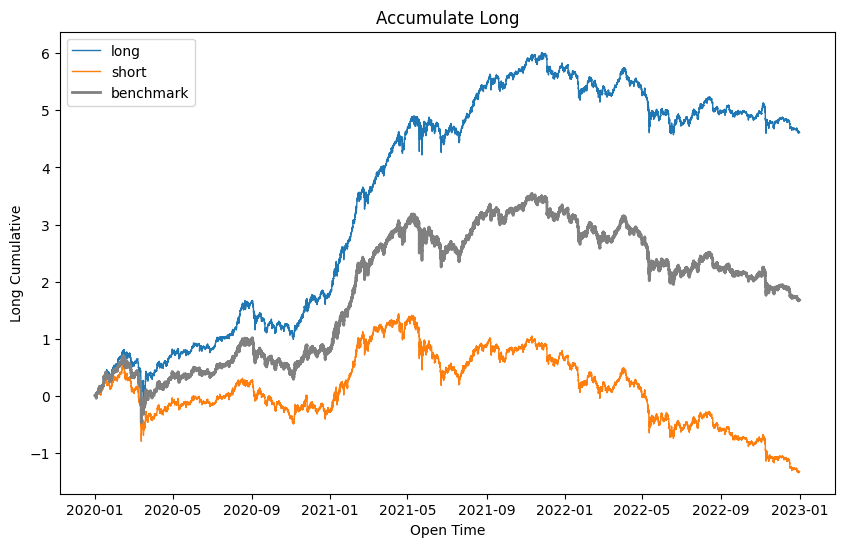

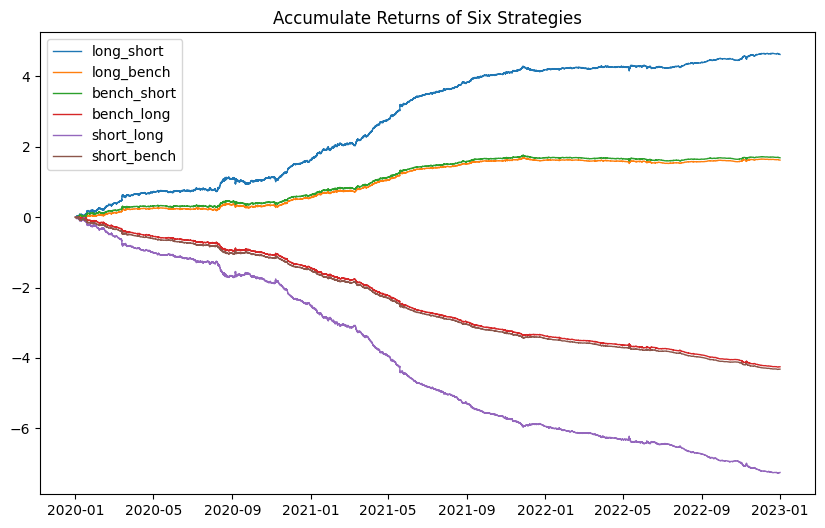

long: 
ann_return = 1.5358  sharpe = 1.3703  maxdd = 0.5656  calmar_ratio = 2.7152  

short: 
ann_return = -0.4432  sharpe = -0.4118  maxdd = 1.1428  calmar_ratio = -0.3878  

bench: 
ann_return = 0.5575  sharpe = 0.513  maxdd = 0.6895  calmar_ratio = 0.8085  

long_short: 
ann_return = 1.5409  sharpe = 4.7005  maxdd = 0.0997  calmar_ratio = 15.4528  

long_bench: 
ann_return = 0.5402  sharpe = 3.2823  maxdd = 0.0854  calmar_ratio = 6.3286  

bench_long: 
ann_return = -1.4162  sharpe = -8.6044  maxdd = 4.2331  calmar_ratio = -0.3346  

short_long: 
ann_return = -2.4169  sharpe = -7.3727  maxdd = 7.2092  calmar_ratio = -0.3353  

short_bench: 
ann_return = -1.4387  sharpe = -8.7079  maxdd = 4.3079  calmar_ratio = -0.334  

bench_short: 
ann_return = 0.5627  sharpe = 3.4058  maxdd = 0.0814  calmar_ratio = 6.9165  



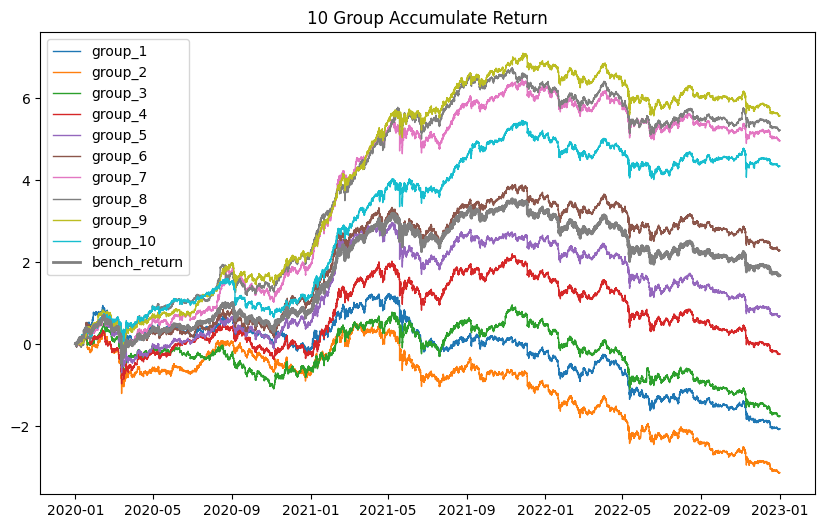

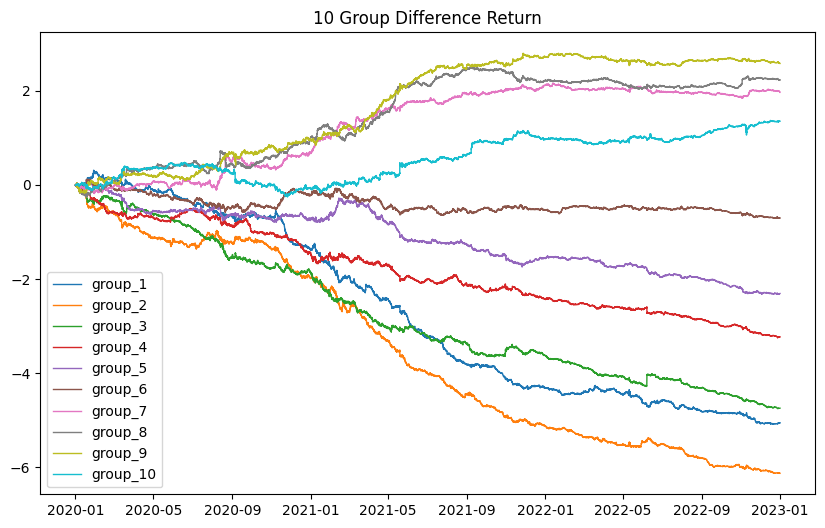

group_1: 
ann_return = -0.6885  sharpe = -0.6306  maxdd = 1.4862  calmar_ratio = -0.4633  

group_2: 
ann_return = -1.0445  sharpe = -0.9338  maxdd = 2.4017  calmar_ratio = -0.4349  

group_3: 
ann_return = -0.5845  sharpe = -0.5105  maxdd = 1.3964  calmar_ratio = -0.4186  

group_4: 
ann_return = -0.0806  sharpe = -0.0707  maxdd = 0.9769  calmar_ratio = -0.0825  

group_5: 
ann_return = 0.2266  sharpe = 0.1955  maxdd = 0.8245  calmar_ratio = 0.2749  

group_6: 
ann_return = 0.761  sharpe = 0.657  maxdd = 0.6999  calmar_ratio = 1.0874  

group_7: 
ann_return = 1.6505  sharpe = 1.4079  maxdd = 0.6806  calmar_ratio = 2.4249  

group_8: 
ann_return = 1.7374  sharpe = 1.48  maxdd = 0.4976  calmar_ratio = 3.4918  

group_9: 
ann_return = 1.8545  sharpe = 1.5475  maxdd = 0.5563  calmar_ratio = 3.3336  

group_10: 
ann_return = 1.4454  sharpe = 1.2574  maxdd = 0.5491  calmar_ratio = 2.6322  

-----------------------------------------
group_difference_1: 
ann_return = -1.684  sharpe = -4.2216 

In [2]:
factors = df.select(['open_time', 'symbol', 'upside_ratio'])

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()